In [1]:
%load_ext ipycache
%load_ext autoreload
%autoreload 2

/miniconda3/lib/python3.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/miniconda3/lib/python3.7/site-packages/ipycache.py:17: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils.traitlets import Unicode


# Initialization
## Hyperparameters for discovery

In [2]:
adsorbate = 'OH'
target_energy = 1.23  # eV
# total_size_limit = 600
initial_training_size = 200
batch_size = 200
quantile_cutoff = 0.95

## Gather validation data

In [3]:
import random
import gzip
import shutil
import ase.db


# Connect to the database. If it hasn't been unzipped yet, then unzip it
db = ase.db.connect('gasdb.db')
if db.count() == 0:
    with gzip.open('gasdb.db.gz', 'rb') as f_in:
        with open('gasdb.db', 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

# Grab the pointers to the data and shuffle
rows = list(db.select())
random.Random(42).shuffle(rows)


def parse_rows(rows):
    features = []
    labels = []
    surfaces = []
    
    for row in rows:
        features.append(row.id)
        data = row.data
        labels.append(data['adsorption_energy'])
        surface = (data['mpid'], data['miller'], data['shift'], data['top'])
        surfaces.append(surface)
    
    return features, labels, surfaces


training_features, training_labels, training_surfaces = parse_rows(rows[:initial_training_size])
sampling_features, sampling_labels, sampling_surfaces = parse_rows(rows[initial_training_size:])

# Hallucinate
## Initialize

In [4]:
import sys
sys.path.insert(0, '../')
from src.discoverers.adsorption.mms import MultiscaleDiscoverer


# Initialize
discoverer = MultiscaleDiscoverer(db_dir='.',
                                  target_energy=target_energy,
                                  quantile_cutoff=quantile_cutoff,
                                  batch_size=batch_size,
                                  training_features=training_features,
                                  training_labels=training_labels,
                                  training_surfaces=training_surfaces,
                                  sampling_features=sampling_features,
                                  sampling_labels=sampling_labels,
                                  sampling_surfaces=sampling_surfaces,
                                  init_train=True  # Set to `False` only for warm starts
                                 )

### Loaded preprocessed data from:  ['./data.pt']


### Loading dataset: gasdb
### Loaded preprocessed data from:  ['./data.pt']
### Loading model: cgcnn
### Loaded CGCNN with 189121 parameters.
cmd:
  checkpoint_dir: /global/cfs/cdirs/m2755/ktran/sandbox/2020/catalyst-acquisitions/notebooks/checkpoints/2020-05-14-15-28-29-cnn
  identifier: cnn
  logs_dir: /global/cfs/cdirs/m2755/ktran/sandbox/2020/catalyst-acquisitions/notebooks/logs/2020-05-14-15-28-29-cnn
  print_every: 100
  results_dir: /global/cfs/cdirs/m2755/ktran/sandbox/2020/catalyst-acquisitions/notebooks/results/2020-05-14-15-28-29-cnn
  seed: null
  timestamp: 2020-05-14-15-28-29-cnn
dataset:
  src: .
  test_size: 9457
  train_size: 30258
  val_size: 7564
logger: wandb
model: cgcnn
model_attributes:
  atom_embedding_size: 64
  fc_feat_size: 128
  num_fc_layers: 4
  num_graph_conv_layers: 6
optim:
  batch_size: 64
  lr_gamma: 0.1
  lr_initial: 0.001
  lr_milestones:
  - 100
  - 150
  max_epochs: 5
  warmup_epochs: 10
  warmup_factor: 0.2
task:
  dataset: gasdb
  description: 

## Run

In [ ]:
discoverer.simulate_discovery()

wandb: WARNING Adding to old History rows isn't currently supported.  Step 1 < 21; dropping {'train/epoch': 0.1, 'train/loss': 0.6207417249679565, 'train/binding energy/mae': tensor(0.5451, grad_fn=<SelectBackward>)}.


### Beginning training on convolutional network.
epoch: 0.1000, loss: 0.6692, binding energy/mae: 0.5876


wandb: WARNING Adding to old History rows isn't currently supported.  Step 2 < 21; dropping {'train/epoch': 0.2, 'train/loss': 0.6183792948722839, 'train/binding energy/mae': tensor(0.5430, grad_fn=<SelectBackward>)}.
wandb: WARNING Adding to old History rows isn't currently supported.  Step 3 < 21; dropping {'train/epoch': 0.3, 'train/loss': 0.7628448605537415, 'train/binding energy/mae': tensor(0.6699, grad_fn=<SelectBackward>)}.
wandb: WARNING Adding to old History rows isn't currently supported.  Step 4 < 21; dropping {'train/epoch': 0.4, 'train/loss': 0.6782292723655701, 'train/binding energy/mae': tensor(0.5956, grad_fn=<SelectBackward>)}.
wandb: WARNING Adding to old History rows isn't currently supported.  Step 5 < 21; dropping {'train/epoch': 0.5, 'train/loss': 0.6632064580917358, 'train/binding energy/mae': tensor(0.5824, grad_fn=<SelectBackward>)}.
wandb: WARNING Adding to old History rows isn't currently supported.  Step 6 < 21; dropping {'train/epoch': 0.6, 'train/loss': 0

### Evaluating on val.


wandb: WARNING Adding to old History rows isn't currently supported.  Step 10 < 21; dropping {'val/loss': 0.7753904879906885, 'val/binding energy/mae': 0.6808951928855617, 'val/epoch': 1}.


loss: 0.7754, binding energy/mae: 0.6809
### Evaluating on test.


wandb: WARNING Adding to old History rows isn't currently supported.  Step 10 < 21; dropping {'test/loss': 0.7842273438546438, 'test/binding energy/mae': 0.6886551060265649, 'test/epoch': 1}.


loss: 0.7842, binding energy/mae: 0.6887


wandb: WARNING Adding to old History rows isn't currently supported.  Step 11 < 21; dropping {'train/epoch': 1.1, 'train/loss': 0.5314574241638184, 'train/binding energy/mae': tensor(0.4667, grad_fn=<SelectBackward>)}.
wandb: WARNING Adding to old History rows isn't currently supported.  Step 12 < 21; dropping {'train/epoch': 1.2, 'train/loss': 0.5765379667282104, 'train/binding energy/mae': tensor(0.5063, grad_fn=<SelectBackward>)}.


epoch: 1.1000, loss: 0.6457, binding energy/mae: 0.5670


wandb: WARNING Adding to old History rows isn't currently supported.  Step 13 < 21; dropping {'train/epoch': 1.3, 'train/loss': 0.6122240424156189, 'train/binding energy/mae': tensor(0.5376, grad_fn=<SelectBackward>)}.
wandb: WARNING Adding to old History rows isn't currently supported.  Step 14 < 21; dropping {'train/epoch': 1.4, 'train/loss': 0.6577503681182861, 'train/binding energy/mae': tensor(0.5776, grad_fn=<SelectBackward>)}.
wandb: WARNING Adding to old History rows isn't currently supported.  Step 15 < 21; dropping {'train/epoch': 1.5, 'train/loss': 0.6313275098800659, 'train/binding energy/mae': tensor(0.5544, grad_fn=<SelectBackward>)}.
wandb: WARNING Adding to old History rows isn't currently supported.  Step 16 < 21; dropping {'train/epoch': 1.6, 'train/loss': 0.5581933259963989, 'train/binding energy/mae': tensor(0.4902, grad_fn=<SelectBackward>)}.
wandb: WARNING Adding to old History rows isn't currently supported.  Step 17 < 21; dropping {'train/epoch': 1.7, 'train/los

### Evaluating on val.


wandb: WARNING Adding to old History rows isn't currently supported.  Step 20 < 21; dropping {'val/loss': 0.7168721409177617, 'val/binding energy/mae': 0.6295083577620698, 'val/epoch': 2}.


loss: 0.7169, binding energy/mae: 0.6295
### Evaluating on test.


wandb: WARNING Adding to old History rows isn't currently supported.  Step 20 < 21; dropping {'test/loss': 0.7254336148805586, 'test/binding energy/mae': 0.6370264583683665, 'test/epoch': 2}.


loss: 0.7254, binding energy/mae: 0.6370
epoch: 2.1000, loss: 0.6278, binding energy/mae: 0.5513
### Evaluating on val.
loss: 0.6946, binding energy/mae: 0.6099
### Evaluating on test.
loss: 0.7043, binding energy/mae: 0.6185
epoch: 3.1000, loss: 0.6172, binding energy/mae: 0.5420
### Evaluating on val.
loss: 0.7019, binding energy/mae: 0.6163
### Evaluating on test.
loss: 0.7104, binding energy/mae: 0.6239
epoch: 4.1000, loss: 0.6010, binding energy/mae: 0.5278
### Evaluating on val.
loss: 0.7723, binding energy/mae: 0.6782
### Evaluating on test.
loss: 0.7818, binding energy/mae: 0.6865
### Beginning training on GP.
Number of devices: 1 -- Kernel partition size: 0
Iter 1/1 - Loss: 0.912   lengthscale: 0.698   noise: 0.164
Finished training on 600 data points using 1 GPUs.
Iter 1/20 - Loss: 0.848   lengthscale: 0.702   noise: 0.121
Iter 2/20 - Loss: 0.740   lengthscale: 0.707   noise: 0.063
Iter 3/20 - Loss: 0.580   lengthscale: 0.713   noise: 0.020
Iter 4/20 - Loss: 0.041   lengthsca

/miniconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1824: RuntimeWarning: divide by zero encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)
wandb: WARNING Adding to old History rows isn't currently supported.  Step 1 < 50; dropping {'train/epoch': 0.0625, 'train/loss': 0.5163363218307495, 'train/binding energy/mae': tensor(0.4534, grad_fn=<SelectBackward>)}.


### Beginning training on convolutional network.
epoch: 0.0625, loss: 0.5863, binding energy/mae: 0.5148


wandb: WARNING Adding to old History rows isn't currently supported.  Step 2 < 50; dropping {'train/epoch': 0.125, 'train/loss': 0.46375542879104614, 'train/binding energy/mae': tensor(0.4072, grad_fn=<SelectBackward>)}.
wandb: WARNING Adding to old History rows isn't currently supported.  Step 3 < 50; dropping {'train/epoch': 0.1875, 'train/loss': 0.4975259304046631, 'train/binding energy/mae': tensor(0.4369, grad_fn=<SelectBackward>)}.
wandb: WARNING Adding to old History rows isn't currently supported.  Step 4 < 50; dropping {'train/epoch': 0.25, 'train/loss': 0.4525116980075836, 'train/binding energy/mae': tensor(0.3974, grad_fn=<SelectBackward>)}.
wandb: WARNING Adding to old History rows isn't currently supported.  Step 5 < 50; dropping {'train/epoch': 0.3125, 'train/loss': 0.4552959203720093, 'train/binding energy/mae': tensor(0.3998, grad_fn=<SelectBackward>)}.
wandb: WARNING Adding to old History rows isn't currently supported.  Step 6 < 50; dropping {'train/epoch': 0.375, 'tr

### Evaluating on val.


wandb: WARNING Adding to old History rows isn't currently supported.  Step 16 < 50; dropping {'val/loss': 0.6427914579845455, 'val/binding energy/mae': 0.5644557388269738, 'val/epoch': 1}.


loss: 0.6428, binding energy/mae: 0.5645
### Evaluating on test.


wandb: WARNING Adding to old History rows isn't currently supported.  Step 16 < 50; dropping {'test/loss': 0.6499199471755387, 'test/binding energy/mae': 0.5707154924126521, 'test/epoch': 1}.


loss: 0.6499, binding energy/mae: 0.5707


wandb: WARNING Adding to old History rows isn't currently supported.  Step 17 < 50; dropping {'train/epoch': 1.0625, 'train/loss': 0.5357288718223572, 'train/binding energy/mae': tensor(0.4704, grad_fn=<SelectBackward>)}.
wandb: WARNING Adding to old History rows isn't currently supported.  Step 18 < 50; dropping {'train/epoch': 1.125, 'train/loss': 0.5255939364433289, 'train/binding energy/mae': tensor(0.4615, grad_fn=<SelectBackward>)}.


epoch: 1.0625, loss: 0.5757, binding energy/mae: 0.5055


wandb: WARNING Adding to old History rows isn't currently supported.  Step 19 < 50; dropping {'train/epoch': 1.1875, 'train/loss': 0.5737061500549316, 'train/binding energy/mae': tensor(0.5038, grad_fn=<SelectBackward>)}.
wandb: WARNING Adding to old History rows isn't currently supported.  Step 20 < 50; dropping {'train/epoch': 1.25, 'train/loss': 0.5956284403800964, 'train/binding energy/mae': tensor(0.5230, grad_fn=<SelectBackward>)}.
wandb: WARNING Adding to old History rows isn't currently supported.  Step 21 < 50; dropping {'train/epoch': 1.3125, 'train/loss': 0.5073110461235046, 'train/binding energy/mae': tensor(0.4455, grad_fn=<SelectBackward>)}.
wandb: WARNING Adding to old History rows isn't currently supported.  Step 22 < 50; dropping {'train/epoch': 1.375, 'train/loss': 0.42967915534973145, 'train/binding energy/mae': tensor(0.3773, grad_fn=<SelectBackward>)}.
wandb: WARNING Adding to old History rows isn't currently supported.  Step 23 < 50; dropping {'train/epoch': 1.437

### Evaluating on val.


wandb: WARNING Adding to old History rows isn't currently supported.  Step 32 < 50; dropping {'val/loss': 0.6609867646881978, 'val/binding energy/mae': 0.580433625064484, 'val/epoch': 2}.


loss: 0.6610, binding energy/mae: 0.5804
### Evaluating on test.


wandb: WARNING Adding to old History rows isn't currently supported.  Step 32 < 50; dropping {'test/loss': 0.6676297043386388, 'test/binding energy/mae': 0.5862670010083342, 'test/epoch': 2}.
wandb: WARNING Adding to old History rows isn't currently supported.  Step 33 < 50; dropping {'train/epoch': 2.0625, 'train/loss': 0.5309888124465942, 'train/binding energy/mae': tensor(0.4663, grad_fn=<SelectBackward>)}.


loss: 0.6676, binding energy/mae: 0.5863
epoch: 2.0625, loss: 0.5622, binding energy/mae: 0.4937


wandb: WARNING Adding to old History rows isn't currently supported.  Step 34 < 50; dropping {'train/epoch': 2.125, 'train/loss': 0.47595417499542236, 'train/binding energy/mae': tensor(0.4180, grad_fn=<SelectBackward>)}.
wandb: WARNING Adding to old History rows isn't currently supported.  Step 35 < 50; dropping {'train/epoch': 2.1875, 'train/loss': 0.5043476819992065, 'train/binding energy/mae': tensor(0.4429, grad_fn=<SelectBackward>)}.
wandb: WARNING Adding to old History rows isn't currently supported.  Step 36 < 50; dropping {'train/epoch': 2.25, 'train/loss': 0.40497153997421265, 'train/binding energy/mae': tensor(0.3556, grad_fn=<SelectBackward>)}.
wandb: WARNING Adding to old History rows isn't currently supported.  Step 37 < 50; dropping {'train/epoch': 2.3125, 'train/loss': 0.38303887844085693, 'train/binding energy/mae': tensor(0.3364, grad_fn=<SelectBackward>)}.
wandb: WARNING Adding to old History rows isn't currently supported.  Step 38 < 50; dropping {'train/epoch': 2.3

### Evaluating on val.


wandb: WARNING Adding to old History rows isn't currently supported.  Step 48 < 50; dropping {'val/loss': 0.6604506177955294, 'val/binding energy/mae': 0.5799628135888544, 'val/epoch': 3}.


loss: 0.6605, binding energy/mae: 0.5800
### Evaluating on test.


wandb: WARNING Adding to old History rows isn't currently supported.  Step 48 < 50; dropping {'test/loss': 0.6676763070058332, 'test/binding energy/mae': 0.5863079203624432, 'test/epoch': 3}.
wandb: WARNING Adding to old History rows isn't currently supported.  Step 49 < 50; dropping {'train/epoch': 3.0625, 'train/loss': 0.5670429468154907, 'train/binding energy/mae': tensor(0.4979, grad_fn=<SelectBackward>)}.


loss: 0.6677, binding energy/mae: 0.5863
epoch: 3.0625, loss: 0.5505, binding energy/mae: 0.4834
### Evaluating on val.
loss: 0.6994, binding energy/mae: 0.6142
### Evaluating on test.
loss: 0.7061, binding energy/mae: 0.6200
epoch: 4.0625, loss: 0.5411, binding energy/mae: 0.4752
### Evaluating on val.
loss: 0.5997, binding energy/mae: 0.5266
### Evaluating on test.
loss: 0.6071, binding energy/mae: 0.5331
### Beginning training on GP.
Number of devices: 1 -- Kernel partition size: 0
Iter 1/1 - Loss: -0.273   lengthscale: 0.693   noise: 0.000
Convergence reached!
Finished training on 1000 data points using 1 GPUs.
Iter 1/20 - Loss: -0.287   lengthscale: 0.693   noise: 0.000
Convergence reached!
Finished training on 1000 data points using 1 GPUs.


In [ ]:
%debug

In [5]:
# Or load the last run
discoverer.load_last_run()

## Analyze

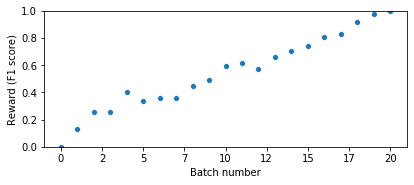

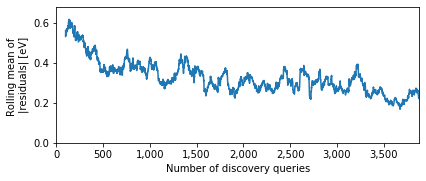

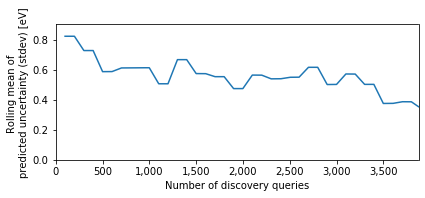

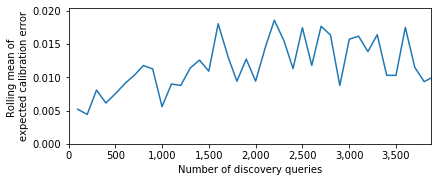

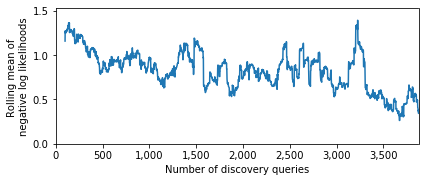

In [8]:
reward_fig, accuracy_fig, uncertainty_fig, calibration_fig, nll_fig = discoverer.plot_performance(window=100)